In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Not needed in notebook

In [2]:
# Training settings
# parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
# parser.add_argument('--batch-size', type=int, default=64, metavar='N',
#                     help='input batch size for training (default: 64)')
# parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
#                     help='input batch size for testing (default: 1000)')
# parser.add_argument('--epochs', type=int, default=10, metavar='N',
#                     help='number of epochs to train (default: 10)')
# parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
#                     help='learning rate (default: 0.01)')
# parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
#                     help='SGD momentum (default: 0.5)')
# parser.add_argument('--no-cuda', action='store_true', default=False,
#                     help='disables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='how many batches to wait before logging training status')
# args = parser.parse_args()
# args.cuda = not args.no_cuda and torch.cuda.is_available()

# torch.manual_seed(args.seed)
# if args.cuda:
#     torch.cuda.manual_seed(args.seed)


# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

# Running from the root makes things easy

In [3]:
%cd ../..

/home/kamen/Workspace/Coursework/year4/mlp/mlp-03


In [4]:
from src.datautils.sandia import SandiaDataProvider

# Setup data provider

In [5]:
train_batch_size = 32
test_batch_size = 8

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('datasets/mnist', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=train_batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('datasets/mnist', train=False, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=test_batch_size, shuffle=True)

train_data = SandiaDataProvider(which_set='train',
                                  dataset_home='datasets/sandia/',
                                  img_size=28)
test_data = SandiaDataProvider(which_set='test',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)
# Reload these every time you start an epoch
train_loader = train_data.get_batch_iterator(train_batch_size)
test_loader = test_data.get_batch_iterator(test_batch_size)

# Define models

In [6]:
lr = 0.01
momentum = 0.5
cuda = True
latent_size = 10

from src.autoencoders import PCA_autoencoder

class ReasoningAgent(nn.Module):
    def __init__(self, latent_size):
        super(ReasoningAgent, self).__init__()
        self.latent_size = latent_size
        self.affine = nn.Linear(latent_size*8, latent_size)
        
    def forward(self, latent_vectors):
        # Reshape num_batch, num_im, latent_size -> num_batch, num_im * latent_size
        num_batch, num_im, latent_size = latent_vectors.size()
        reshaped_latent = latent_vectors.view(num_batch, num_im * latent_size)
        latent_prediction = self.affine(reshaped_latent)
        return latent_prediction
    
class Architecture(nn.Module):
    def __init__(self, latent_size):
        super(Architecture, self).__init__()
        self.latent_size = latent_size
        self.autoencoder = PCA_autoencoder(self.latent_size)
        self.reasoning_agent = ReasoningAgent(self.latent_size)
        
    def forward(self, inputs):
        # inputs and choices are num_batch, im_width, im_height, num_im
        num_batch, im_width, im_height, num_im = inputs.size()
        
        # These are in the shape <num_questions, imsize, imsize, 16(8Q + 8A)> - transpose and reshape so that they are
        # in the shape <num_images, img_size **2 >
        flattened_inputs = inputs.permute(0, 3, 1, 2).contiguous().view(-1, im_width * im_height)

        # Get latent vectors
        latent_inputs = self.autoencoder.encode(flattened_inputs.cpu().data.numpy())
        
        # Convert to Torch variable
        latent_inputs = torch.from_numpy(latent_inputs).float()
        if cuda:
            latent_inputs = latent_inputs.cuda()
        latent_inputs = Variable(latent_inputs)
        
        # Reshape to regain structure of problem
        latent_inputs = latent_inputs.view(num_batch, num_im, self.latent_size)
        
        # Get latent prediction
        latent_prediction = self.reasoning_agent(latent_inputs)
        
        return latent_prediction
    
model = Architecture(100)
# model = Autoencoder(10)
if cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Train models

In [7]:
log_interval = 50
losses = []
            
def train(epoch, matrix_types=None):
    train_data = SandiaDataProvider(which_set='train',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  matrix_types=matrix_types)
    train_loader = train_data.get_batch_iterator(train_batch_size)
    
    # Pretrain the PCA encoder
    X = train_data.inputs.transpose(3, 0, 1, 2).reshape(-1, 28 * 28)
    model.autoencoder.train(X)
    model.train()
    # Get new gen object at every epoch
    for batch_idx, (data, labels) in enumerate(train_loader):
        batch_size = len(data)
        data, labels = torch.from_numpy(data).float(), torch.from_numpy(labels).long()
        if cuda:
            data, labels = data.cuda(), labels.cuda()
        data, labels = Variable(data), Variable(labels)
        optimizer.zero_grad()
        latent_predictions = model(data[:, :, :, :8])
        choices = data[:, :, :, 8:].permute(3, 0, 1, 2)
        indices = torch.from_numpy(np.arange(len(data))).long()
        if cuda:
            indices = indices.cuda()
        targets = choices[labels.data, indices].squeeze()
        # Get latent representations of targets
        targets = targets.view(batch_size, -1)
        latent_targets = model.autoencoder.encode(targets.cpu().data.numpy())
        # Convert to Torch variable
        latent_targets = torch.from_numpy(latent_targets).float()
        if cuda:
            latent_targets = latent_targets.cuda()
        latent_targets = Variable(latent_targets)
        loss = F.mse_loss(latent_predictions, latent_targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        if batch_idx % log_interval == 0:
            print('Train Epoch: {0} Loss: {1:.6f}'.format(epoch, loss.data[0]))

def test(matrix_types=None):
    model.eval()
    test_loss = 0
    correct = 0
    # Get a fresh generator object
    test_data = SandiaDataProvider(which_set='test',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  matrix_types=matrix_types,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)
    test_loader = test_data.get_batch_iterator(test_batch_size)
    for batch_idx, (data, labels) in enumerate(test_loader):
        batch_size = len(data)
        data, labels = torch.from_numpy(data).float(), torch.from_numpy(labels).long()
        if cuda:
            data, labels = data.cuda(), labels.cuda()
        data, labels = Variable(data), Variable(labels)
        optimizer.zero_grad()
        latent_predictions = model(data[:, :, :, :8])
        choices = data[:, :, :, 8:].permute(3, 0, 1, 2)
        indices = torch.from_numpy(np.arange(len(data))).long()
        if cuda:
            indices = indices.cuda()
        targets = choices[labels.data, indices].squeeze()
        # Get latent representations of targets
        targets = targets.view(batch_size, -1)
        latent_targets = model.autoencoder.encode(targets.cpu().data.numpy())
        # Convert to Torch variable
        latent_targets = torch.from_numpy(latent_targets).float()
        if cuda:
            latent_targets = latent_targets.cuda()
        latent_targets = Variable(latent_targets)
        test_loss += F.mse_loss(latent_predictions, latent_targets, size_average=False).data[0]
        residuals = latent_targets - latent_predictions
        squared_error = residuals ** 2
        pred = squared_error.data.min(1, keepdim=True)[1] # get the index of the min mse choice
        correct += pred.eq(labels.data.view_as(pred)).cpu().sum()

    test_loss /= test_data.size()
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_data.size(),
        100. * correct / test_data.size()))

epochs = 20
for epoch in range(1, epochs + 1):
    train(epoch)
#     train_autoencoder_only(epoch)
test(['1_layer'])

Train Epoch: 1 Loss: 9.873007
Train Epoch: 2 Loss: 5.634491
Train Epoch: 3 Loss: 4.647928
Train Epoch: 4 Loss: 4.074780
Train Epoch: 5 Loss: 3.694221
Train Epoch: 6 Loss: 3.418321
Train Epoch: 7 Loss: 3.205344
Train Epoch: 8 Loss: 3.033415
Train Epoch: 9 Loss: 2.890053
Train Epoch: 10 Loss: 2.767620
Train Epoch: 11 Loss: 2.661149
Train Epoch: 12 Loss: 2.567250
Train Epoch: 13 Loss: 2.483509
Train Epoch: 14 Loss: 2.408144
Train Epoch: 15 Loss: 2.339799
Train Epoch: 16 Loss: 2.277419
Train Epoch: 17 Loss: 2.220162
Train Epoch: 18 Loss: 2.167347
Train Epoch: 19 Loss: 2.118416
Train Epoch: 20 Loss: 2.072904

Test set: Average loss: 769.1137, Accuracy: 0/10 (0%)



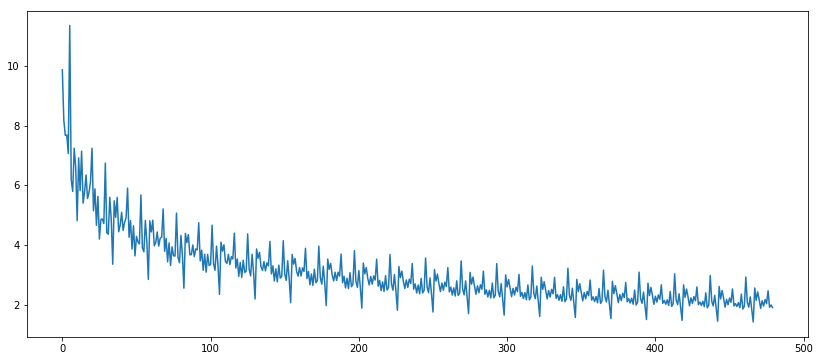

In [8]:
plt.figure(figsize=(14,6))
plt.plot(losses);

In [47]:
test_batch_size = 1
batch_size, data, latent_targets = None, None, None
test_loader = test_data.get_batch_iterator(test_batch_size)

In [48]:
for batch_idx, (data, labels) in enumerate(test_loader):
    batch_size = len(data)
    data, labels = torch.from_numpy(data).float(), torch.from_numpy(labels).long()
    if cuda:
        data, labels = data.cuda(), labels.cuda()
    data, labels = Variable(data), Variable(labels)
    optimizer.zero_grad()
    latent_predictions = model(data[:, :, :, :8])
    choices = data[:, :, :, 8:].permute(3, 0, 1, 2)
    indices = torch.from_numpy(np.arange(len(data))).long()
    if cuda:
        indices = indices.cuda()
    targets = choices[labels.data, indices].squeeze()
    # Get latent representations of targets
    targets = targets.view(batch_size, -1)
    latent_targets = model.autoencoder.encode(targets.cpu().data.numpy())
    # Convert to Torch variable
    latent_targets = torch.from_numpy(latent_targets).float()
    if cuda:
        latent_targets = latent_targets.cuda()
    latent_targets = Variable(latent_targets)
    break

In [49]:
def show_batch_of_images(img_batch, img_size=(1,1), grid_size=None):
    # How many squares for a square grid that can fit all images
    if grid_size == None:
        grid_size = math.ceil(math.sqrt(len(img_batch)))
        grid_size = (grid_size, grid_size)
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(img_size[0] * grid_size[0], img_size[1] * grid_size[1]))
    # Turn the 2d array of axes to a 1d array
    axs = axs.flatten()
    for i, img in enumerate(img_batch):
        axs[i].imshow(img.reshape(28,28))
    # Do this separately in case the number of images we want to show is not a perfect square
    for i in range(grid_size[0] * grid_size[1]):
        axs[i].axis('off')
    plt.show()

In [50]:
setup = data[:, :, :, :8]
setup = setup.permute(3, 0, 1, 2).cpu().data.numpy()
setup = setup.reshape(-1, 28, 28)

In [51]:
originals = targets.cpu().data.numpy().reshape(-1, 28, 28)

In [52]:
decoded_predictions = model.autoencoder.decode(latent_predictions.cpu().data.numpy()).reshape(-1, 28, 28)

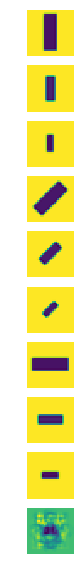

In [54]:
show_batch_of_images(np.concatenate([setup, originals, decoded_predictions]), img_size=(test_batch_size, 10), grid_size=(10, test_batch_size))

In [39]:
encoded = model.encoder(data)
eps = Variable(torch.randn(encoded.size())).cuda()
encoded_jittered = encoded + eps * 10

In [40]:
jittered_reconstruction = model.decoder(encoded_jittered)

In [47]:
start, end = data[5, :], data[3, :]
fades = start
for i in range(1, test_batch_size - 1):
    coeff = i / (test_batch_size - 1)
    new = end * coeff + start * (1 - coeff)
    fades = torch.cat((fades, new), 0)
fades = torch.cat((fades, end), 0) 

In [48]:
originals = data.view(test_batch_size, 28, 28).cpu().data.numpy()
reconstructions = output.view(test_batch_size, 28, 28).cpu().data.numpy()
jittered = jittered_reconstruction.view(test_batch_size, 28, 28).cpu().data.numpy()
faded = fades.view(test_batch_size, 28, 28).cpu().data.numpy()

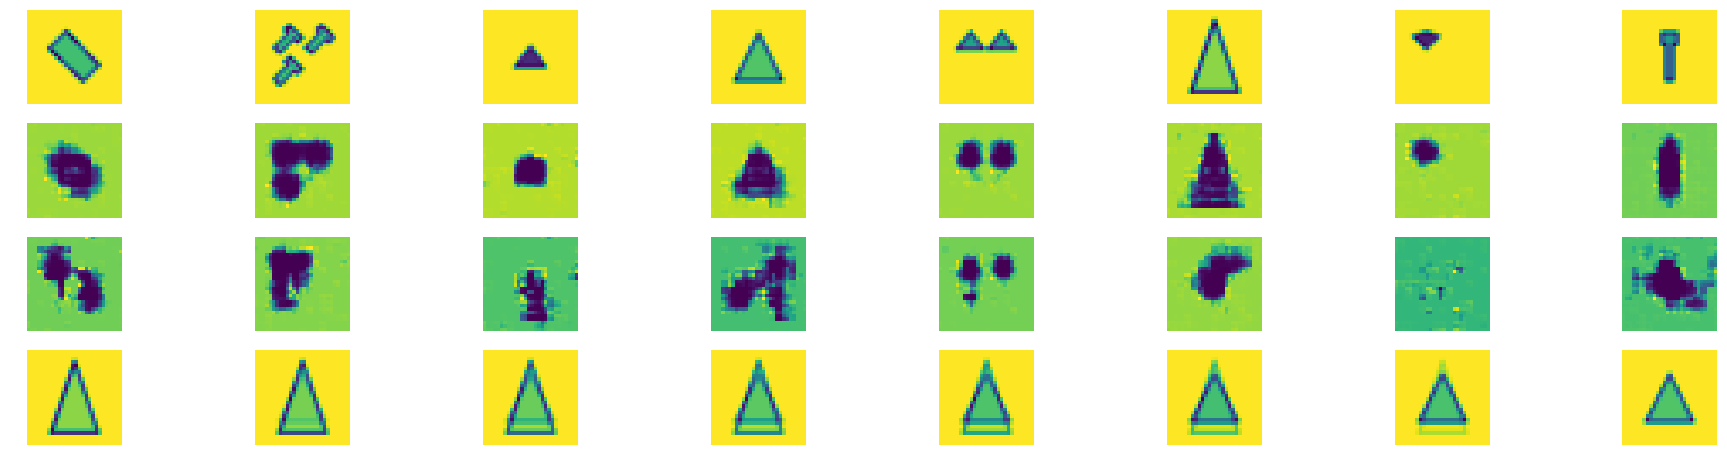

In [49]:
def show_batch_of_images(img_batch, img_size=(1,1), grid_size=None):
    # How many squares for a square grid that can fit all images
    if grid_size == None:
        grid_size = math.ceil(math.sqrt(len(img_batch)))
        grid_size = (grid_size, grid_size)
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(img_size[0] * grid_size[0], img_size[1] * grid_size[1]))
    # Turn the 2d array of axes to a 1d array
    axs = axs.flatten()
    for i, img in enumerate(img_batch):
        axs[i].imshow(img.reshape(28,28))
    # Do this separately in case the number of images we want to show is not a perfect square
    for i in range(grid_size[0] * grid_size[1]):
        axs[i].axis('off')
    plt.show()

show_batch_of_images(np.concatenate([originals, reconstructions, jittered, faded]), img_size=(test_batch_size, 1), grid_size=(4, test_batch_size))